# Basics of parallel and distributed computing with DASK

## Recap on Task Parallelization (this time using Dask)

By now, we should be quite familiar with the programming pattern discussed in previous lectures, where we explored Hadoop MapReduce and the Spark framework.

Apart from the specifics of the API, which vary depending on the framework implementation, and the internal workings of job scheduling and resource management, most distributed computing frameworks and tools offer ways to parallelize our tasks through graph schedulers and task optimizers.

The workflow remains largely consistent, regardless of the tool used:
- **Subdivide large datasets that won't fit into memory into smaller subsets (partitions)**
- **Design the entire data processing pipeline before execution and optimize it by breaking it into smaller tasks**
- **Schedule and distribute processing close to the data, minimizing data movement (data locality)**

In Dask, we have access to a variety of dataset representations:

- Dask bag (roughly equivalent to the Spark RDD)
- Dask array
- Dask dataframe (similar to the Spark DataFrame)

However, it's important to note that Dask primarily serves as a **scheduler**, written in Python as opposed to Scala \[*\], which allows for the lazy execution of Python-like code, distributing it across multiple workers.

_\[*\] Please note that the fact that Dask's scheduler is written in Python does not necessarily make it better than Spark for most purposes. Both Python and Scala/Java have their own strengths and weaknesses. For instance, due to Python's memory management approach, Dask still faces challenges with unmanaged memory over the lifecycle of an application. For more information, you can refer to this [link](https://coiled.io/blog/tackling-unmanaged-memory-with-dask/)._


## Starting a cluster

We can use Dask locally to leverage the multitasking/processing capabilities of our local machine, or we can set up a cluster and deploy a scheduler and multiple worker nodes.

Once the cluster is set up, we can initialize a `Client` by providing it with the address of a scheduler.

In [1]:
# import the dask distributed client
from dask.distributed import Client

# instantiate the client by providing 
# the address:port of the scheduler
client = Client('dask-scheduler:8786')

# inspect the client
client

<Client: 'tcp://172.23.0.2:8786' processes=3 threads=3, memory=1.43 GiB>

We can monitor the status of the cluster with a dedicated webui by accessing the location (IP address) of the scheduler/master node at port `8787`.
Using Docker with the appropriate port-mapping (provided in the Docker compose file) we can access the dashboard on `localhost:8787`.

The dashboard provides an overview of both the status of the workers, and the execution of the DAG task graphs (when we begin using them).

## Simple parallelization of python functions

_In the following, we will follow a similar approach to the one provided by the excellent Dask documentation._

The simplest example of parallelizing any arbitrary Python code in Dask can be demonstrated with a couple of simple operations, represented by two functions and an arbitrary sleep time of 1 second.

_The sleep time is meant to represent arbitrarily complex code (___your___ task) and the time required for its execution._


In [2]:
from time import sleep

# dummy function incrementing the input value by 1
def increment(x):
    # sleep for 1s
    sleep(1)
    # given the input x, return x+1
    return x + 1

# dummy function decrementing the input value by 1
def decrement(x):
    # sleep for 1s
    sleep(1)
    # given the input x, return x-1
    return x - 1

# dummy function summing two input values
def add(x, y):
    # sleep for 1s
    sleep(1)
    # given the inputs x and y, return x+y
    return x + y

These are purely Python functions...

We can test the functions locally by running them on the client (not on the cluster).

In [3]:
%%time

# we should expect a wall-time of roughly 3 seconds (3x 1sec sleep)
x = increment(1)
y = decrement(2)
z = add(x, y)

CPU times: user 9.37 ms, sys: 0 ns, total: 9.37 ms
Wall time: 3 s


In order for Dask to leverage the processing units assigned to the cluster, we need to construct the Directed Acyclic Graph (DAG) corresponding to the execution of the code we want to deploy on the cluster. Subsequently, we allow the scheduler to dispatch the tasks to the workers.

This is accomplished in Dask by marking a function as `delayed`.

The `delayed` method in Dask accepts two main arguments:
- The first argument is the function to be executed in parallel.
- The subsequent arguments are the arguments upon which the original function will operate.

Now, we aim to transform the `increment`, `decrement`, and `add` functions, thereby making them **lazy**.


In [4]:
# import the dask delayed module
from dask import delayed

In [5]:
%%time

# make the function behave as lazy with delayed
#
# result = delayed(your_function)(<your_function_arguments>)
x = delayed(increment)(1)
y = delayed(decrement)(2)
z = delayed(add)(x, y)

CPU times: user 240 µs, sys: 568 µs, total: 808 µs
Wall time: 754 µs


At this stage, as is typical with lazy operations, the results are not yet stored in `z`.

At this stage, `z` simply represents the "plan" of the code execution, created by the Directed Acyclic Graph (DAG) task scheduler.

To visualize the plan of execution, we can utilize the `visualize()` method (note that the `graphviz` Python package is required for this).

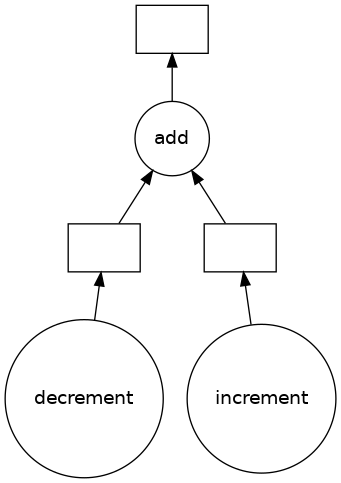

In [6]:
# dask offers a nice and simple 
# visualization of the DAG
z.visualize()

This visualization represents the task graph **before** any optimization is applied.

We can also request Dask to provide the DAG **after** optimization by using the `optimize_graph=True` option.

For this simple task, we shouldn't anticipate significant optimization. However, with more complex tasks, we can expect to see a noticeable difference.

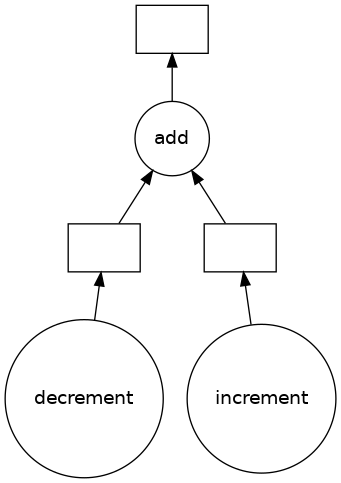

In [7]:
# optimized DAG
z.visualize(optimize_graph=True)

Alternatively, Dask also offers a high-level task visualization tool that can be accessed by clicking on it from within a Jupyter notebook.

In [8]:
# high-level task graph
z.dask

HighLevelGraph with 3 layers.
<dask.highlevelgraph.HighLevelGraph object at 0x7f1a3c3d8bd0>
 0. decrement-9fcf6805-8a0d-4d1d-bc91-04f686bab25d
 1. increment-c707266e-7847-4f91-815d-d7a2ecee9a60
 2. add-6b58e8c7-f3cc-4b6d-9234-b22f3b424164

To actually execute the job, we need to instruct Dask to trigger the execution by requesting the results of the lazy operation with the `compute()` method.

Under the hood, Dask will send the computational graph to the scheduler and dispatch the tasks to the workers, similar to what was discussed for Spark.

It's important to note that `compute()` is a blocking operation, meaning that the program will wait for the results to be computed before proceeding.

In [9]:
%%time

# the execution time should now be 
# less than the 3 seconds measured above
# 
# ideally, we should expect 2 seconds:
#  - 1 second (sleep time) to run the increment and decrement functions --in parallel--
#  - 1 second (sleep time) to run the add function based on the results of the previous stages
z.compute() 

CPU times: user 3.76 ms, sys: 8.56 ms, total: 12.3 ms
Wall time: 2.05 s


3

## Futures and Eager computation with `submit`

The eager operation alternative to `delayed` in Dask is `submit`.

Using `submit` instructs Dask to immediately submit our task to the cluster and begin executing it on the available computing resources.

This approach is quite similar, and in fact, almost equivalent to the concept of a batch system.


In [10]:
# submit the function increment with argument 1
# return a "promise" of getting the actual result
future = client.submit(increment, 1)

The function `increment` with its argument `1` is submitted to the cluster, and the `future` object is returned immediately. 
However, this `future` object **does not contain the result of the computation**; rather, it represents an execution **promise** of the instruction that was submitted. 
It's important to note that the execution may not have been completed yet, as the cluster might take some time to process it.

The `future` variable **does not contain the result** itself, but rather a promise of it for when the computation is completed. 

**The result of the computation will remain on the worker nodes of our cluster and will not be sent back to our client until we explicitly request it.**

This concept is particularly useful when dealing with large computation results or when subsequent tasks need to be executed on the data resulting from previous tasks.

To retrieve the result from the cluster to the client, we can invoke the `gather` function on the `future` object.


In [11]:
# the promise of the result
future

<Future: finished, type: int, key: increment-3d2e1b65a1e75bf97a06d5e8e87a4fef>

In [12]:
# the result, gathered from the cluster
client.gather(future)

2

This approach can be extremely useful in situations where we need to submit a task multiple times, potentially with different input parameters. 

This scenario is common in machine learning, especially when optimizing an algorithm across a hyperparameter space for a specific dataset.

The concept behind this approach allows us to `map` the instruction we want to execute to each element of a dataset, effectively submitting the same operation across the entire dataset.

_In practical terms, we are parallelizing our function in a manner similar to how it's done with the Python `multiprocessing` module, but leveraging a large and horizontally scalable set of computing resources._


In [13]:
# restart from a list of integers
data = [0, 1, 2, 3, 4, 5, 6, 7, 8]

# submit the increment function on ALL elements of the list
# using a `map` approach (each element is independent from the others)
future_results = client.map(increment, data)

# this execution is Eager and Asynchronous  
future_results

[<Future: pending, key: increment-589baedaec5eb70f7176c3f4cc5447e0>,
 <Future: finished, type: int, key: increment-3d2e1b65a1e75bf97a06d5e8e87a4fef>,
 <Future: pending, key: increment-545ab9130b2d8370a36f51ca38a053a1>,
 <Future: pending, key: increment-9bfd9887708ee8e6c037b0ac8cfec4d6>,
 <Future: pending, key: increment-aeb92da11192bb4d23b6573d09c05928>,
 <Future: pending, key: increment-6d4b082ccb453642cf21c70583661929>,
 <Future: pending, key: increment-c80862144ea651d37f80234c03bcc3c4>,
 <Future: pending, key: increment-a3679bea8374a4416b75ad1a8f9746a9>,
 <Future: pending, key: increment-7394c227b75e788d05c5997151b53db5>]

In [14]:
# check the status of the jobs
future_results

[<Future: finished, type: int, key: increment-589baedaec5eb70f7176c3f4cc5447e0>,
 <Future: finished, type: int, key: increment-3d2e1b65a1e75bf97a06d5e8e87a4fef>,
 <Future: finished, type: int, key: increment-545ab9130b2d8370a36f51ca38a053a1>,
 <Future: finished, type: int, key: increment-9bfd9887708ee8e6c037b0ac8cfec4d6>,
 <Future: finished, type: int, key: increment-aeb92da11192bb4d23b6573d09c05928>,
 <Future: finished, type: int, key: increment-6d4b082ccb453642cf21c70583661929>,
 <Future: finished, type: int, key: increment-c80862144ea651d37f80234c03bcc3c4>,
 <Future: pending, key: increment-a3679bea8374a4416b75ad1a8f9746a9>,
 <Future: pending, key: increment-7394c227b75e788d05c5997151b53db5>]

In [15]:
# retrieve the data from the cluster
new_data = client.gather(future_results)

print(new_data)

[1, 2, 3, 4, 5, 6, 7, 8, 9]


`client.map` operates **asynchronously**, meaning that the cluster computes the results without blocking our local Python code for task completion.

Think of it in terms of `process.start()` and `process.join()` in multiprocessing.

However, **if** we need to wait for the result of a `submit` computation to be ready — for instance, if we require it as an input for other computations — we can use the `wait` method. This method blocks the execution of new code and waits for the computation of the future.


In [16]:
# import the dask wait 
from dask.distributed import wait

# start the computation
new_future = client.map(increment, new_data)

# block this python process 
# and wait for the remote task to be completed
wait(new_future)

DoneAndNotDoneFutures(done={<Future: finished, type: int, key: increment-c80862144ea651d37f80234c03bcc3c4>, <Future: finished, type: int, key: increment-aeb92da11192bb4d23b6573d09c05928>, <Future: finished, type: int, key: increment-545ab9130b2d8370a36f51ca38a053a1>, <Future: finished, type: int, key: increment-7394c227b75e788d05c5997151b53db5>, <Future: finished, type: int, key: increment-9cb4002707265bd2756e1998afd8e9e7>, <Future: finished, type: int, key: increment-a3679bea8374a4416b75ad1a8f9746a9>, <Future: finished, type: int, key: increment-6d4b082ccb453642cf21c70583661929>, <Future: finished, type: int, key: increment-3d2e1b65a1e75bf97a06d5e8e87a4fef>, <Future: finished, type: int, key: increment-9bfd9887708ee8e6c037b0ac8cfec4d6>}, not_done=set())

In [17]:
# the result, gathered from the cluster
client.gather(new_future)

[2, 3, 4, 5, 6, 7, 8, 9, 10]

In complete analogy to what we have discussed with the `delayed` lazy execution, we can combine multiple instructions that need to be submitted to the cluster to create a more complex job to run on our cluster.

It's important to remember that the results of the `submit` execution reside on the cluster until a `gather` is used.

This means that **we can submit a task that takes as an argument an execution promise** of an instruction that has been previously submitted*.

The `gather` function should be invoked at the end of the program, only when the results need to be effectively retrieved from the cluster.


In [18]:
# submit the increment function
x = client.submit(increment, 1)
# submit the decrement function
y = client.submit(decrement, 2)

# submit the add function
#
# this will run on the promises of the results 
# of both the x and y (possibly not yet available)
total = client.submit(add, x, y)

In [19]:
# this is still the execution promise
print(total)          

<Future: finished, type: int, key: add-7d1ad072e3b4b54d763298627cc9aba5>


In [20]:
# this is the final result
client.gather(total)  

3

## Exercise 1: Parallelization of a for loop

At this point, with the previous knowledge of what discussed with Spark, and the `delayed` and `compute` Dask operations, we should already be able to run simple "dummy" tasks.

Starting from a list $\vec{x}$ of values:
1. write a function to increment each element $x_i$ by a random value $\delta x_i$ (in the 0-1 range)
2. write a function to multiply the resulting value by 10
3. loop over $\vec{x}$ and apply both functions on each $x_i$ element using the `delayed`
4. retrieve the sum of all the new updated elements
5. visualize the task graph

In [21]:
import random
import time

# input data
data = [1, 2, 3, 4, 5, 6, 7, 8]

# 1. increment function
def add_rand(x):
    return x+random.random()

# 2. multiplication function
def mult_ten(x):
    return x*10

# placeholder for the updated array
results = []

# 3. for each element
#  - add a random value
#  - multiply by ten
#  - append the new data in a list
for x in data:
    y = delayed(add_rand)(x)
    z = delayed(mult_ten)(y)
    results.append(z)

    
# 4. sum all elements of the list
total = delayed(sum)(results)

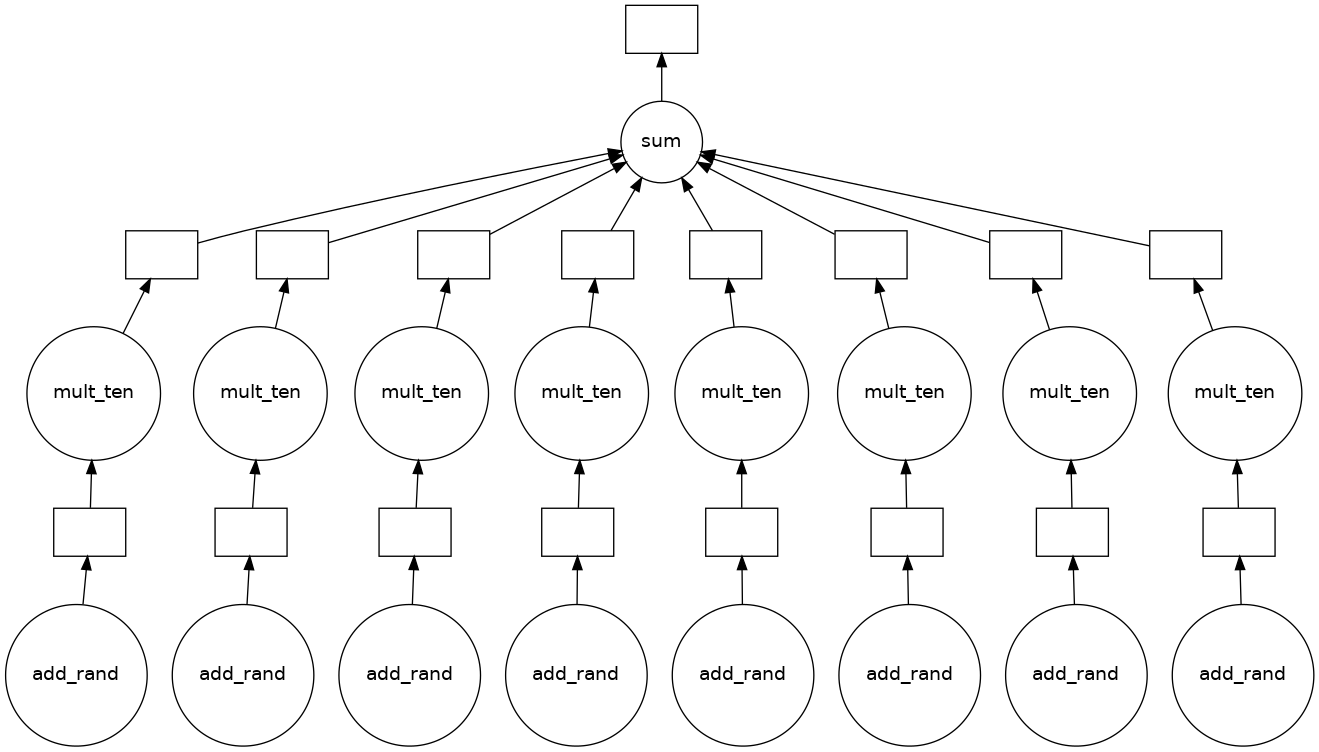

In [22]:
# 5. visualize the task graph
total.visualize()

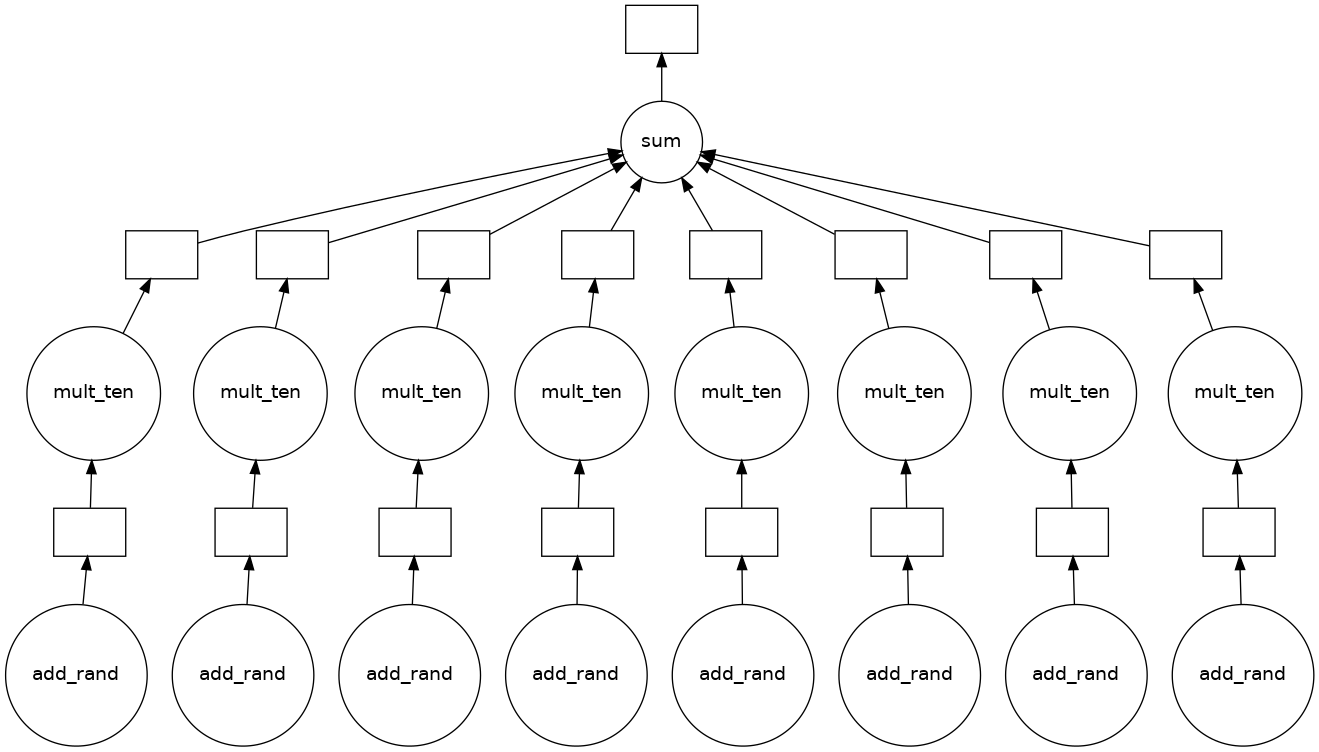

In [23]:
# visualize the Optimized task graph
# 
# once again, we should not expect any real optimization 
# to be viable for this map-like operations
total.visualize(optimize_graph=True)

In [24]:
%%time

# compute the result and time it
result = total.compute()

CPU times: user 9.34 ms, sys: 0 ns, total: 9.34 ms
Wall time: 84.6 ms


In [25]:
# check the result
print("result: ",result)

result:  398.441611030525


#### Run the same task with the eager `submit` execution approach

In [26]:
# input data
data = [1, 2, 3, 4, 5, 6, 7, 8]

# placeholder for the updated array
results = []

# for each element
#  - add a random value
#  - multiply by ten
#  - append the new data in a list
for x in data:
    y = client.submit(add_rand, x)
    z = client.submit(mult_ten, y)
    results.append(z)


    
# sum of all elements of the list
total = client.submit(sum, results)

In [27]:
# print the future object
total

<Future: finished, type: float, key: sum-2c7b55d0033b672be8ac629b080d12e5>

In [28]:
# print the result
print("result: ",client.gather(total))

result:  399.62639468522184


There is clearly another alternative to the previous approach using the **map** Dask functionality:

In [29]:
# input data
data = [1, 2, 3, 4, 5, 6, 7, 8]

# map both functions on all data elements
y = client.map(add_rand, data)
z = client.map(mult_ten, y)

# submit the sum function on the z future
total = client.submit(sum, z)

In [30]:
# print the future object
total

<Future: finished, type: float, key: sum-c60806c3bc8c41757bd1b100c6177d15>

In [31]:
# print the result
print("result: ",client.gather(total))

result:  403.8115669423396


## Exercise 2: Map Reduce with Dask

So far, we have primarily used _map_-like operations and then collected all outputs in a single `sum` operation.

Now, we need to explore how we could write in Dask an equivalent _reduce_ function to evaluate the sum of a list of elements pair-wise.

We can utilize the `add` function previously defined, which includes a 1-second sleep time, to visualize the time taken to run the task.



Here is a pair-reduction algorithm implemented with a (_"nasty"_) nested `for` loop and some simple Python logic.


In [32]:
%%time

L = [1, 2, 3, 4, 5, 6, 7, 8, 9]

while len(L) > 1:
    # Temporary list to store the sum of pairs
    _ = []  
    
    # Iterate over the indices of L with a step of 2 to process pairs of elements    
    for i in range(0, len(L), 2):
        if i+1 < len(L):
            # Sum pairs of elements in the list
            pair_sum = add(L[i], L[i + 1]) 
        else:
            # If the length of L is odd, add the last element with 0
            pair_sum = add(L[i], 0)       
        _.append(pair_sum)  # Append the sum to the temporary list
    
    # Replace L with the temporary list containing pair sums
    L = _  

# Print the final result
print("result:",L[0])  

result: 45
CPU times: user 16.6 ms, sys: 0 ns, total: 16.6 ms
Wall time: 11 s


To parallelize this reduce task, we can define the pair-wise sum of neighbor elements as `delayed`.

In [33]:
%%time

L = [1, 2, 3, 4, 5, 6, 7, 8, 9]

# rewrite the same algorithm using delayed
while len(L) > 1:
    _ = []
    for i in range(0, len(L), 2):
        if i+1 < len(L):
            pair_sum = delayed(add)(L[i], L[i + 1])
        else:
            pair_sum = delayed(add)(L[i], 0)       
        _.append(pair_sum)
    L = _ 

CPU times: user 2.43 ms, sys: 4.11 ms, total: 6.54 ms
Wall time: 5.63 ms


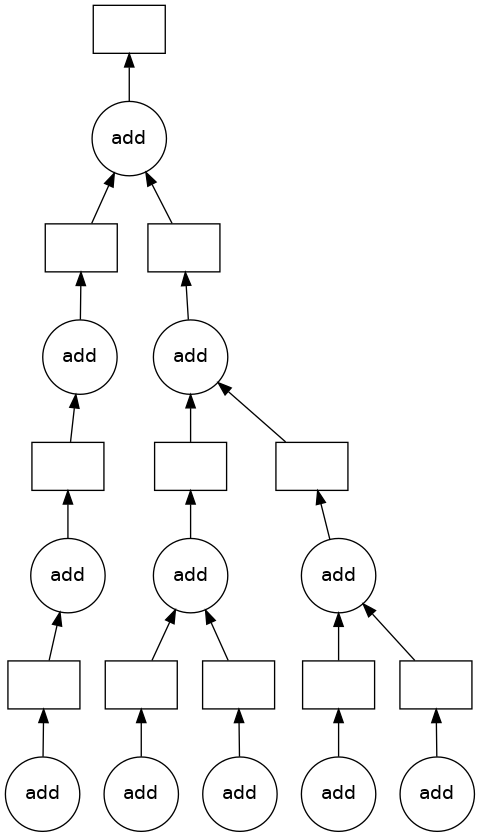

In [34]:
# visualize the task graph for L[0]
L[0].visualize()

In [35]:
%%time 

# compute the result
result = L[0].compute()

CPU times: user 2.19 ms, sys: 14.4 ms, total: 16.6 ms
Wall time: 5.05 s


In [36]:
print("result",result)

result 45


## Exercise 3: Count how many words are present in a series of documents

Given a dataset composed of pieces of text taken from `sklearn`, the task is to count how many words are present in each document and calculate the total number of words in the dataset.

The dataset consists of approximately 8000 documents.

While one way to proceed would be to loop over all documents and count the words in each, a more efficient approach is needed, and we should now know how to do it.

In [37]:
from sklearn.datasets import fetch_20newsgroups
from dask.distributed import Client
import time

categories = [
     'comp.graphics',
     'comp.os.ms-windows.misc',
     'comp.sys.ibm.pc.hardware',
     'comp.sys.mac.hardware',
     'comp.windows.x',
     'misc.forsale',
     'rec.autos',
     'rec.motorcycles',
     'rec.sport.baseball',
     'rec.sport.hockey',
     'sci.crypt',
     'sci.electronics',
     'sci.med',
     'sci.space'
]

dataset = fetch_20newsgroups(subset='train', categories=categories ).data

In [39]:
print("Documents in the dataset:",len(dataset))

Documents in the dataset: 8283


In [40]:
# a simple function to split a body of text 
# into words and count them
def count_words(text):
    words = text.split()
    return len(words)

A simple example of single-threaded execution in plain Python can be the following

In [41]:
%%time

# initialize a word-per-document list
total_words_per_document = []

# count the number of words in each document
for document in dataset:
    total_words_per_document.append(count_words(document))

# calculate the total number of words in the dataset
total_words_dataset = sum(total_words_per_document)

CPU times: user 176 ms, sys: 0 ns, total: 176 ms
Wall time: 172 ms


In [42]:
print(f"Total number of words in the dataset: {total_words_dataset}")

Total number of words in the dataset: 2038444


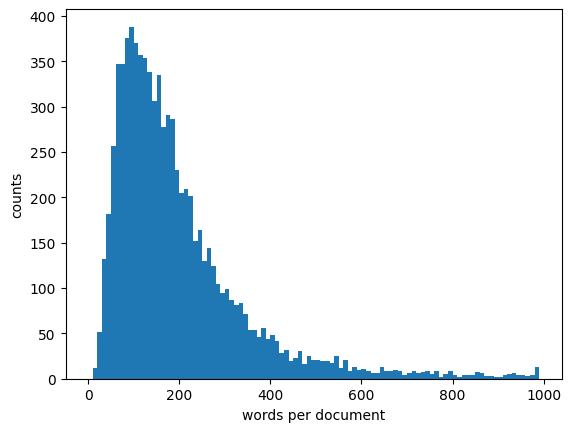

In [43]:
import matplotlib.pyplot as plt

plt.hist(total_words_per_document,bins=range(0,1000,10));
plt.xlabel('words per document');
plt.ylabel('counts');

#### Implement the distributed version using the `delayed` lazy execution

In [48]:
%%time

# initialize a word-per-document list
total_words_per_document = []


# count the number of words in each document
# using dask delayed 
for document in dataset:
    total_words_per_document.append(delayed(count_words)(document))


# calculate the total number of words in the dataset
# using dask delayed 
total_words_lazy = delayed(sum)(total_words_per_document)

CPU times: user 659 ms, sys: 0 ns, total: 659 ms
Wall time: 654 ms


In [49]:
%%time

# execute the tasks and retrieve the result
lazy_result = total_words_lazy.compute()

print(f"Total number of words in the dataset: {lazy_result}")

Total number of words in the dataset: 2038444
CPU times: user 348 ms, sys: 11.7 ms, total: 360 ms
Wall time: 13.6 s


#### Implement the distributed version using the `map` and `submit` eager execution

In [66]:
%%time

# count the number of words in each document
# using dask map 
future_results = client.map(count_words, dataset)


# calculate the total number of words in the dataset
# using dask submit 
total_words_eager = client.submit(sum, future_results)

CPU times: user 1.04 s, sys: 0 ns, total: 1.04 s
Wall time: 1.02 s


/usr/local/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 14.21 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [67]:
# check the future object
total_words_eager

<Future: pending, key: sum-0674b9633f577af0f7b44e2328460e17>

In [68]:
eager_result = client.gather(total_words_eager)
print("Total number of words in the dataset: {}".format(eager_result))

Total number of words in the dataset: 2038444


## Exercise 4: Calculate the first $n$ Fibonacci numbers

Let's define the plain Python algorithm to evaluate the sequence of Fibonacci up to the $n$-th element:

Once again, let's start from some simple single-threaded Python code for this:

In [69]:
def fibonacci_sequential(num):
    iteration = 1
    fibonacci = []
    if num <= 0:
        pass
    elif num == 1:
        fibonacci.append(1)
    elif num == 2:
        fibonacci.append(1)
        fibonacci.append(1)
    elif num > 2:
        fibonacci.append(1)
        fibonacci.append(1)
        while iteration < (num - 1):
            fibonacci.append(fibonacci[iteration] + fibonacci[iteration-1])
            iteration+=1
    return fibonacci

In [70]:
# test it
n = 17

print(f"The first {n} fibonacci numbers are: {fibonacci_sequential(n)}")

The first 17 fibonacci numbers are: [1, 1, 2, 3, 5, 8, 13, 21, 34, 55, 89, 144, 233, 377, 610, 987, 1597]


#### Implement the same algorithm using the Dask lazy evaluation, with `delayed`, and inspect the task graph

In [71]:
# in order to generalize the append we need 
# to create a function that does not get 
# an error when called with an empty array
def append(arr = [], val = 0):
    if val != None:
        arr.append(val)
    return arr

# define the delayed version of the fibonacci code
def fibonacci_delayed(num):
    


SyntaxError: incomplete input (2648680391.py, line 10)

In [ ]:
# test it
result = fibonacci_delayed(8)

In [ ]:
# visualize the graph
result.visualize(rankdir="LR")

In [ ]:
# compute
result.compute()

## Exercise 5: Monte Carlo Integration

Let's assume we want to integrate of a function via MonteCarlo technique, as you have discussed in LCP Module A.

Let's use the function $$f(x) =\sin^2{\left(\frac{1}{x(2-x)}\right)}$$ and let's integrate in the range $(0,2)$

In [ ]:
import numpy as np

def f(x):
    return (np.sin(1/(x*(2-x))))**2

x=np.linspace(-0.2,2.2,4000)

plt.figure(figsize=(16,6));
plt.plot(x,f(x),'grey','.');
plt.fill_between(x[np.where((x>0) & (x<2))],[1]*len(np.where((x>0) & (x<2))), alpha=0.2);
plt.fill_between(x[np.where((x>0) & (x<2))],f(x[np.where((x>0) & (x<2))]), alpha=0.2);
plt.vlines([0, 2], 0, 1, colors = ["k", "k"], linestyles = ["dashed", "dashed"],linewidths=[3,3],zorder=20);
plt.xlabel('x');
plt.ylabel('$f(x)$');

Create the single-threaded Python code to execute this task, and evaluate the integral over N=100 000 points

In [ ]:
%%time
# Monte Carlo integration using Python's built-in random module

# number of points to use for integration
N = 100000

# list of counts for points that pass the function test
count = []

# function to check if a random point is passing
def pass_function():
    # generate a random x value between 0 and 2
    # generate a random y value between 0 and 1
    x = 2 * random.random()
    y = random.random()
    # check if the point (x, y) is under the curve defined by f(x)
    return 1 if y < f(x) else 0

# iterate over all points and count how many pass the function test
for i in range(N):
    count.append(pass_function())

# compute the integral by dividing the sum of the counts by the total number of points,
# and multiply by the width of the integration range (2)
I = 2 * sum(count) / N

# print the result
print(f"Integral = {I}")

#### Apply the minimal changes to the code to deploy the same integral computation on the Dask cluster using `delayed`

**NOTE**: Do NOT use 100 000 points in this case, but ___limit the computation to N=1 000 points___

In [ ]:
%%time
# Monte Carlo integration using Python's built-in random module

# number of points to use for integration
N = 1_000



We can even use Python **decorators** to declare that an entire function is going to be interpreted as `delayed`

```python
@dask.delayed
def my_delayed_function(arg):
    ...
    return val
```

In [ ]:
%%time
# Monte Carlo integration using Python's built-in random module

# import dask to use its delayed decorator
import dask


Why are we experiencing degraded performance compared to single-threaded execution?

The Dask code may exhibit slower performance than the equivalent plain Python code due to the **overhead** introduced by Dask itself.

When utilizing Dask, we construct a task graph that Dask must traverse to execute the computation. This process involves additional computation and communication overhead between the scheduler and the workers, contributing to increased execution time compared to the plain Python version.

_Each delayed task inherently incurs an overhead of hundreds of microseconds. With a large number of computations issued, this overhead can become significant._

Furthermore, our usage of `delayed` to parallelize the computation may not fully exploit Dask's parallelism capabilities. By creating a list of `delayed` objects and then computing them all at once with `delayed(sum)(count)`, we essentially execute 1000 `count` functions as individual processes on the worker nodes.

This approach can be inefficient since it still processes the loop sequentially before aggregating the results in parallel. A more effective strategy could involve leveraging Dask's `dask.bag` to parallelize the computation more efficiently.

Overall, it's crucial to ensure that we maximize Dask's capabilities to parallelize the computation effectively. In some scenarios, utilizing Dask may not yield any performance benefits and could potentially be slower than plain Python if the task is not optimized for parallel execution.

## Exercise 6: $\pi$ via MonteCarlo

We can re-run the evaluation of $\pi$ using the Monte Carlo technique, similar to what was done during the Spark hands-on session.

However, it's important to note that, at present, we haven't partitioned the data in Dask (yet).

Instead, we're instructing Dask to execute a simple task for each entry in our list, which incurs significant overhead.

Therefore, it's advisable to start with a very limited number of points, approximately 10, and gradually increase to a maximum of around 100. 
This cautious approach allows us to monitor the job's status from the dashboard and assess its performance effectively.

In [ ]:
%%time

import random

# set the number of points to use
num_points = 100

# list to hold the points inside the circle
points_in_circle = []

# function to check if a point is inside the circle
def in_circle():
    # generate a random x and y value between 0 and 1

    
# iterate over all the points and count how many are inside the circle


# count the number of points inside the circle
num_points_inside = 

# compute pi
pi = 4*num_points_inside/num_points

In [ ]:
# print result
print (f"{pi=}")

#### Use `delayed` to parallelize the computation

In [ ]:
%%time



In [ ]:
# print result
print (f"{pi=}")

#### Use `map` or `submit` to parallelize the computation using the Dask eager execution

With `submit` we have to be very careful...

Naively calling `client.map` with a function that returns a random variable may result in the same exact random value being returned every time. Essentially, we have _one function_ executed 10000 times.

However, we can inform Dask that this function is `impure`, meaning it can produce different output values for the same input:

```python
client.submit(your_function, pure=False)
```

This approach ensures that we obtain 10000 different random variables. However, it's important to note that while this guarantees diversity in the random variables, it can pose challenges for Dask's parallelization. We may encounter unnecessary overhead and performance penalties due to the increased complexity introduced by impure functions.



In [ ]:
%%time 



In [ ]:
# print result
print (f"{pi=}")

### Take-away Message

Dask offers flexibility in scheduling our Pythonic code and tasks, allowing for both lazy and eager execution strategies.

However, as discussed, parallelization tends to be most beneficial for tasks involving substantial data or computationally intensive operations that can be divided into smaller chunks and executed concurrently.

The simple functions used in our examples do not represent computationally "heavy" tasks well, and thus, the benefits of parallelization (if any at all) may not be fully realized.

Moreover, Dask Distributed can yield significant performance gains when computations are distributed across multiple nodes or machines, rather than just across a few CPU cores on a single machine (as in our case using Docker compose).

Given these factors, it's always essential to thoroughly evaluate the performance of parallelized code and compare it against single-threaded implementations to ensure that the desired efficiency gains are achieved.

## Stop client

In [ ]:
client.close()

Finally, use `docker compose down` to stop and clear all running containers.